# RC model calibration: deterministic versus stochastic models

### author: Simon Rouchier, LOCIE, Université Savoie Mont-Blanc

This notebook describes the procedure for the calibration of a simple 2R2C model. It follows the methodology described in :

Rouchier, S., Rabouille, M., & Oberlé, P. (2018). Calibration of simplified building energy models for parameter estimation and forecasting: Stochastic versus deterministic modelling. Building and Environment, 134, 181-190.

https://hal.archives-ouvertes.fr/hal-01739625


The target is to estimate the heat loss coefficient of the experimental facility shown here:

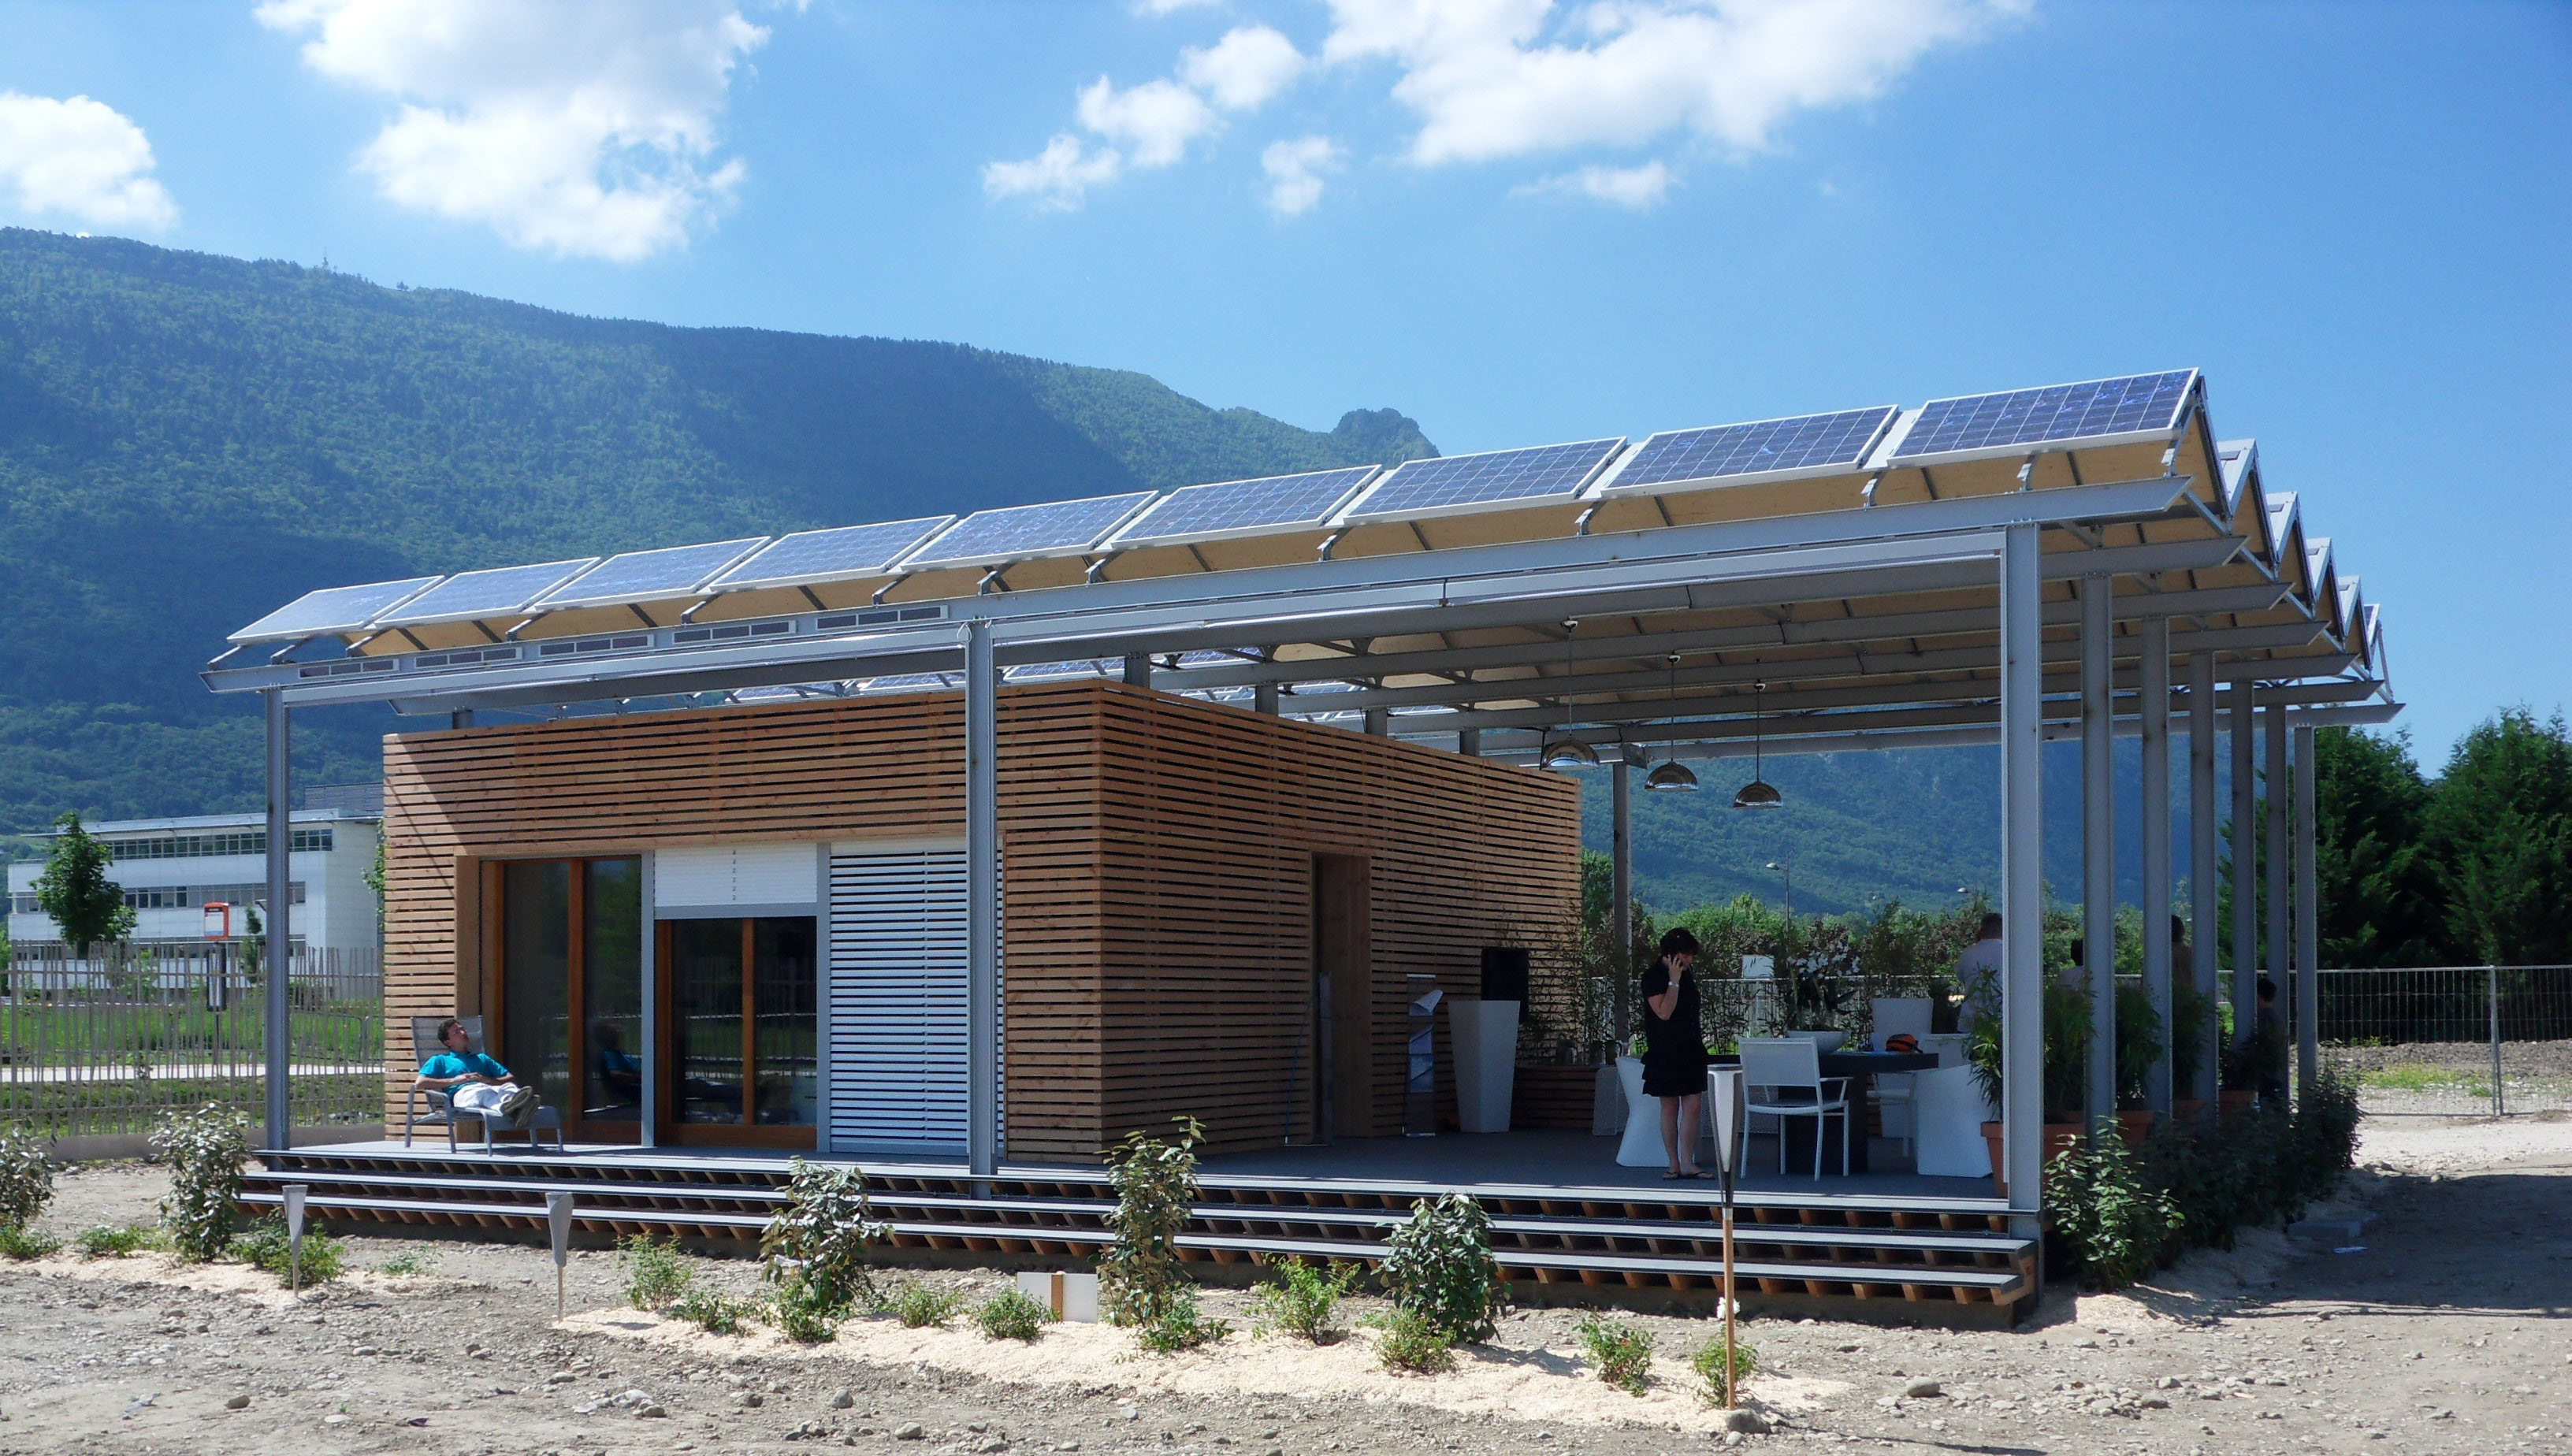

In [1]:
%matplotlib inline

from IPython.display import Image
Image("armadillo-box-ines.jpg", width=400)

The given dataset has 4 days of data, including a 24h period with a heating signal inside the test facility.

Let's start by importing some libraries and opening the data. The data is provided in the file `ArmadilloData.csv`

In [2]:
# Some mandatory imports
import numpy as np
from scipy.linalg import expm
from numpy.linalg import inv

# Two small functions we will need later
def dot3(A,B,C):
    return np.dot(A, np.dot(B,C))
    
def stack4(A,B,C,D):
    return np.vstack((np.hstack((A,B)), np.hstack((C,D))))

# Importing the data
import pandas
dataset = pandas.read_csv('ArmadilloData.csv')
time_ = np.array(dataset['Time'])
T_in  = np.array(dataset['T_int'])  # indoor temperature
T_ext = np.array(dataset['T_ext'])  # outdoor temperature
P_hea = np.array(dataset['P_hea'])  # indoor prescribed heat (W)
I_sol = np.array(dataset['I_sol'])  # solar irradiance  (W/m2)

# We assemble the data into an input array u and an output array y
delta_t = time_[1] - time_[0]       # time step size
u = np.vstack([T_ext ,P_hea, I_sol]).T
y = T_in

In order to estimate the heat transfer coefficient, we use a 2R2C model

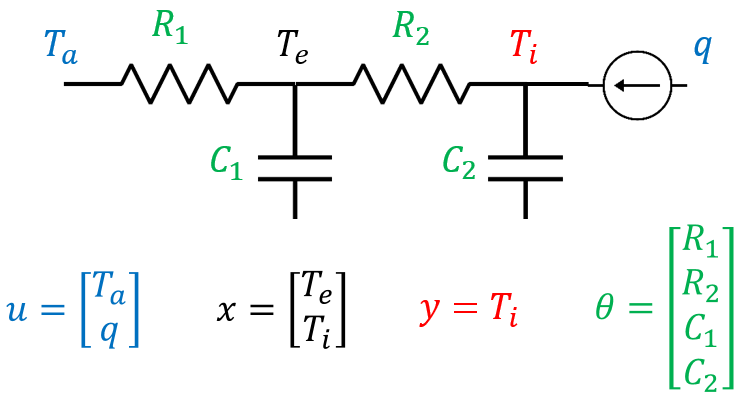

In [3]:
from IPython.display import Image
Image("model_2R2C.png", width=400)

The model that we actually use here is slighly more complex that on the figure since we will add the influence of solar irradiance. It has 7 parameters that we will estimate at once by calibrating the model
* 2 thermal resistances $R_1$ and $R_2$
* 2 thermal capacities $C_1$ and $C_2$
* 2 solar aperture coefficients $k_1$ and $k_2$
* The initial temprature of the unobserved state $x_{e0}$

As a first step, we will consider that the model is unbiased and deterministic: the modelling error is neglected.

In [4]:
# Definition of a simple deterministic model
# This function predicts the indoor temperature Ti as a function of the 
# input u and all model parameters

def RC_model_deterministic(u, R1, R2, C1, C2, k1, k2, xe_0):
    
    # Matrices of the system in continuous form
    Ac = np.array([[-1/(C1*R1)-1/(C1*R2), 1/(C1*R2)],
                   [1/(C2*R2), -1/(C2*R2)]])
    Bc = np.array([[1/(C1*R1), 0, k1/C1],
                   [0, 1/C2, k2/C2]])
    n = 2   # number of states
    # Matrices of the discretized state-space model
    F = expm(Ac*delta_t)
    G = dot3(inv(Ac), F-np.eye(n), Bc)
    H = np.array([[0, 1]])
    
    # Initialisation of the states
    x = np.zeros((len(u), n))
    x[0] = np.array((xe_0, T_in[0]))
    
    # Simulation
    for i in range(1,len(u)):
        x[i] = np.dot(F, x[i-1]) + np.dot(G, u[i-1])
    
    # This function returns the second simulated state only
    return np.dot(H, x.T).flatten()

Now all we have to do is call any curve fitting algorithm we want. Here I used the Levenberg-Marquardt algorithm in the scipy.optimize library.

You need to specify some initial values for the search of parameters: they are called `theta_init` here.

In [5]:
# Curve fitting
"""
This section evaluates the parameters of the model using observations T_in
Note that the initial condition on the unobserved state is an unknown parameter

You should provide an initial guess for the parameters
initial guess for resistances R1 and R2: 1e-2 W/K
initial guess for capacitances C1 and C2: 1e7 J/K
initial guess for solar coefficients k1 and k2: 0.5 m2
initial guess for the initial envelope temperature: 20 C
"""    

from scipy.optimize import curve_fit

theta_init = [1e-2, 1e-2, 1e7, 1e7, 0.5, 0.5, 20]
popt, pcov = curve_fit(RC_model_deterministic,
                       xdata = u,
                       ydata = T_in,
                       p0 = theta_init,
                       method='lm')

`popt` is the optimal value of the parameters and `pcov` is their covariance matrix.

Now we need to validate our results. Here are some possible tests:
* the correlation matrix indicates whether there are high interactions between parameters
* the t_stat is used for parameter significance tests

In [6]:
# Standard deviation of the parameter estimates
stdev = np.diag(pcov)**0.5
# Correlation matrix
R = dot3( np.linalg.inv(np.diag(stdev)), pcov, np.linalg.inv(np.diag(stdev)))
# t-statistic
t_stat = popt / stdev

We can also plot the indoor temperature predicted by the optimal parameters of our fitted model:

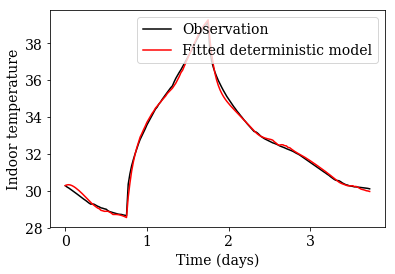

In [7]:
# Calculating the indoor temperature predicted with the optimal parameters
T_in_det = RC_model_deterministic(u, popt[0], popt[1], popt[2], popt[3], popt[4], popt[5], popt[6])

# Plotting curve fitting results

import matplotlib.pyplot as plt
plt.rc('font', **{'family' : 'serif', 'size'   : 14 })

plt.figure()
plt.plot(time_/24/3600, T_in, '-k', linewidth=1.5, label='Observation')
plt.plot(time_/24/3600, T_in_det, '-r', linewidth=1.5, label='Fitted deterministic model')
plt.xlabel('Time (days)')
plt.ylabel('Indoor temperature')
plt.legend()
plt.show()

It looks good right?

But we assumed that our model is deterministic. What if we do the same with a stochastic model?

Here is the code for the prediction of $T_{in}$ with a Kalman filter. The model has three additional parameters: two terms of modelling noise $q_1$ and $q_2$, and one term of measurement noise $r$.

In [8]:
def RC_model_stochastic(u, R1, R2, C1, C2, k1, k2, xe_0, q1, q2, r):

    # Matrices of the continuous model
    Ac = np.array([[-1 / (C1 * R1) - 1 / (C1 * R2), 1 / (C1 * R2)],
                   [1 / (C2 * R2), -1 / (C2 * R2)]])
    Bc = np.array([[1 / (C1 * R1), 0, k1 / C1],
                   [0, 1 / C2, k2 / C2]])

    n = 2       # number of states
    t = len(u)  # number of data points

    # Matrices of the discretized state-space model
    F = expm(Ac * delta_t)
    G = dot3(inv(Ac), F - np.eye(n), Bc)
    H = np.array([[0, 1]])

    # Discretized system noise
    Qc = np.diag([q1 ** 2, q2 ** 2])
    foo = expm(stack4(-Ac, Qc, np.zeros(np.shape(Ac)), Ac.T) * delta_t)
    Q = np.dot(foo[n:2 * n, n:2 * n].T, foo[0:n, n:2 * n])

    # Discretized measurement noise
    Rc = np.array([[r ** 2]])
    R = Rc / delta_t

    # Initialisation
    x_0 = np.array((xe_0, T_in[0]))
    P_0 = np.eye(2)

    # Initialisation of blank arrays to save states, errors, etc.
    x_predict = np.zeros((t, n))
    P_predict = np.zeros((t, n, n))
    x_predict[0] = x_0
    P_predict[0] = P_0

    x_update = np.zeros((t, n))
    P_update = np.zeros((t, n, n))
    x_update[0] = x_0
    P_update[0] = P_0

    epsilon = np.zeros(t)  # prediction errors (innovations)
    Sigma = np.zeros(t)  # innovation covariances

    for i in range(1, t):

        # Predict
        x_predict[i] = np.dot(F, x_update[i - 1]) + np.dot(G, u[i - 1])
        P_predict[i] = dot3(F, P_update[i - 1], F.T) + Q

        # Residuals and Kalman gain
        epsilon[i] = y[i] - np.dot(H, x_predict[i])
        foo = dot3(H, P_predict[i], H.T) + R
        Sigma[i] = foo
        K = dot3(P_predict[i], H.T, np.linalg.inv(foo))

        # Update
        x_update[i] = x_predict[i] + np.dot(K, y[i] - np.dot(H, x_predict[i]))
        P_update[i] = P_predict[i] - dot3(K, H, P_predict[i])

    X = np.dot(H, x_predict.T).flatten()
    S = Sigma

    return X

Now that the stochastic model is defined, we can calibrate it the same way as we did the deterministic:

In [9]:
theta_init = [1e-2, 1e-2, 1e7, 1e7, 0.5, 0.5, 20, 0.1, 0.1, 0.1]
popt2, pcov2 = curve_fit(RC_model_stochastic,
                         xdata = u,
                         ydata = T_in,
                         p0 = theta_init,
                         method='lm')


And once we have the optimal parameters, plot the temperature prediction of the fitted model.

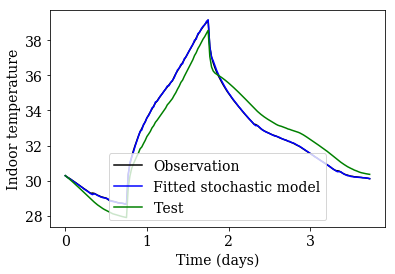

In [10]:
T_in_sto = RC_model_stochastic(u, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4], popt2[5], popt2[6], popt2[7], popt2[8], popt2[9])
T_test = RC_model_deterministic(u, popt2[0], popt2[1], popt2[2], popt2[3], popt2[4], popt2[5], popt2[6])


plt.figure()
plt.plot(time_/24/3600, T_in, '-k', linewidth=1.5, label='Observation')
plt.plot(time_/24/3600, T_in_sto, '-b', linewidth=1.5, label='Fitted stochastic model')
plt.plot(time_/24/3600, T_test, '-g', linewidth=1.5, label='Test')
plt.xlabel('Time (days)')
plt.ylabel('Indoor temperature')
plt.legend()
plt.show()

The model fits the data perfectly thank to the Kalman filter.

Now let's compare the two models. First let's have a look on the estimated values of both thermal resistances, by the deterministic and the stochastic model

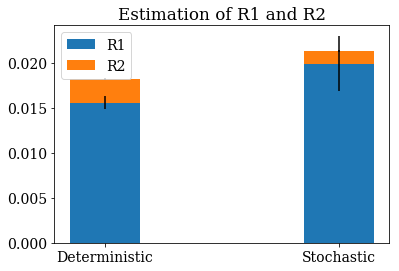

In [11]:
# First we can visualize parameter estimates and their error bar
parameter_list = ['R1', 'R2', 'C1', 'C2', 'k1', 'k2', 'x_0']

ind = [1, 2]    # the x locations for the groups
width = 0.3       # the width of the bars: can also be len(x) sequence

plt.figure()
plt.title('Estimation of R1 and R2')
# plt.bar(ind, [theta_det, theta_sto], width, yerr=[theta_det_std, theta_sto_std])
p1 = plt.bar(ind, [popt[0], popt2[0]], width, yerr=[pcov[0,0]**0.5*2, pcov2[0,0]**0.5*2])
p2 = plt.bar(ind, [popt[1], popt2[1]], width, bottom = [popt[0], popt2[0]], yerr=[pcov[1,1]**0.5*2, pcov2[1,1]**0.5*2])
plt.xticks(ind, ['Deterministic', 'Stochastic'])
plt.legend((p1[0], p2[0]), ('R1', 'R2'))
plt.show()

The uncertainty of the stochastic model is much higher. Does it mean the deterministic model is "better"?

Let's check the residuals to see if they look like white noise.

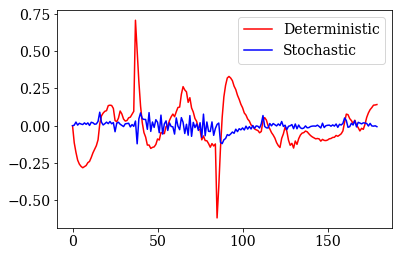

In [12]:
#%% We can also compare residuals

plt.figure()
plt.plot(T_in-T_in_det, '-r', linewidth=1.5, label='Deterministic')
plt.plot(T_in-T_in_sto, '-b', linewidth=1.5, label='Stochastic')
plt.legend()
plt.show()

The residuals of the stochastic model are not so bad, but those of the deterministic model are clearly not white noise: the parameters estimated by this model are probably not reliable.